In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')
from UZ_utils import *

sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/assignment3')
from a3_utils import *


Mounted at /content/drive


EX 1a OK

Iy(x,y) = d[g(x)*g(y)*I(x,y)] / dy = g(x) * ( d[g(y)]/dy * I(x,y) )

Iyy(x,y) = d[g(x)*g(y)*I(x,y)] / dy = g(x) * ( d[g(y)]/dy * Iy(x,y) )

Ixy(x,y) = d[g(x)*g(y)*I(x,y)] / dy = g(x) * ( d[g(y)]/dy * Ix(x,y) )

EX 1b OK

0.0
1.0


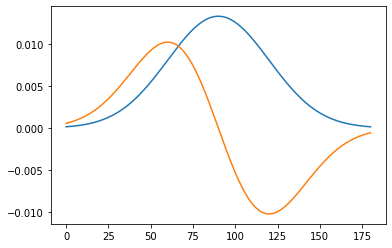

In [ ]:
def gaussian(o=2):
  N = int(np.ceil(3*o))
  k = np.zeros(2*N+1)
  inter = np.arange(-N,N+1)
  return 1/(np.sqrt(2*np.pi)*o) * np.exp(-1*(np.square(inter)/(2*o*o)))


def gaussdx(o=2):
  N = int(np.ceil(3*o))
  k = np.zeros(2*N+1)
  inter = np.arange(-N,N+1)
  not_normal = -1/(np.sqrt(2*np.pi)*o*o*o)*inter * np.exp(-1*(np.square(inter)/(2*o*o)))
  #not_normal = -1* not_normal # flip kernel as it is not symmetric
  return not_normal/np.sum(np.abs(not_normal))

o=30
plt.plot(gaussian(o))
plt.plot(gaussdx(o))
print(np.sum(gaussdx(o))) # = 0
print(np.sum(np.abs(gaussdx(o)))) # = 1

EX 1c OK

In [ ]:
def filter(I, kernel2D):
  I_k = cv2.filter2D(src=I, ddepth=-1, kernel = kernel2D)
  return I_k

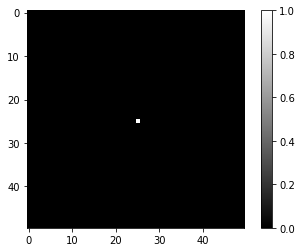

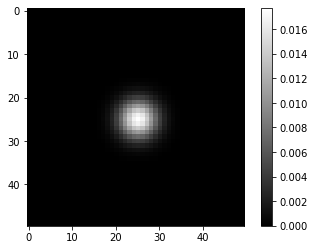

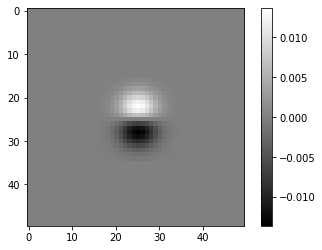

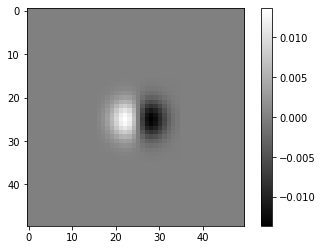

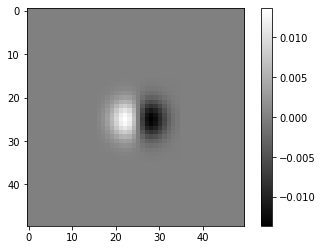

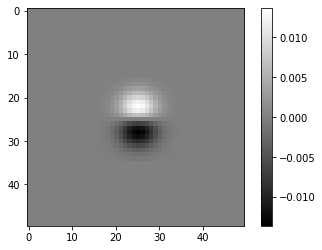

In [ ]:
o = 3
G = -1* gaussian(o) # convolution
G = G.reshape(1,len(G))
D = gaussdx(o)
D = D.reshape(1,len(D))

impulse = np.zeros((50,50))
impulse[25,25] = 1.

imshow(impulse)
imshow(filter(filter(impulse, G),G.T))
imshow(filter(filter(impulse, G),D.T)) # y
imshow(filter(filter(impulse, D),G.T)) # x
imshow(filter(filter(impulse, G.T),D)) # x
imshow(filter(filter(impulse, D.T),G)) # y




EX 1d MEN SE ZDI KUL

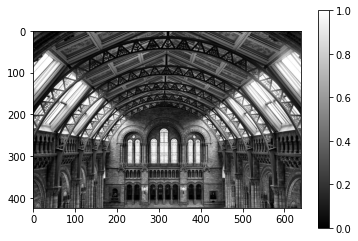

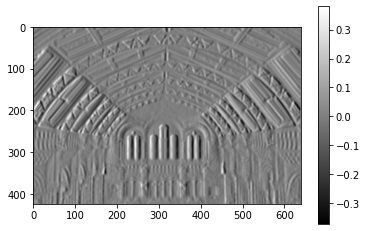

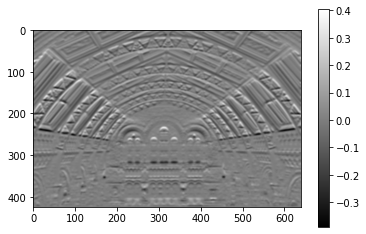

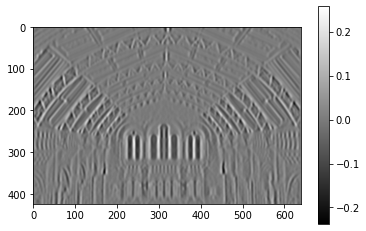

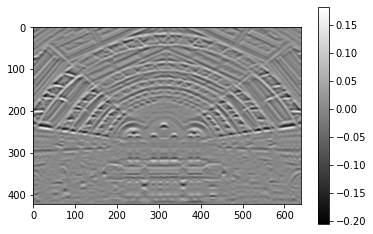

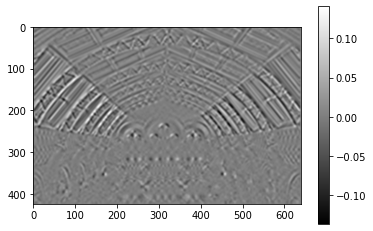

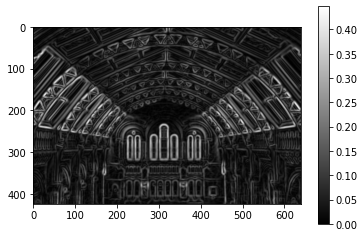

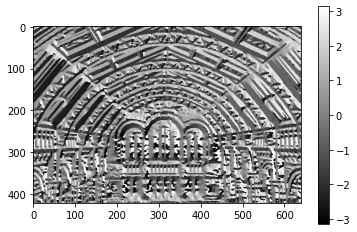

In [ ]:
def get_G_D(o):
  G = -1*gaussian(o)
  G = G.reshape(1,len(G))
  D = gaussdx(o)
  D = D.reshape(1,len(D))
  return (G,D)

def part_deriv_x(I,o):
  G,D = get_G_D(o)
  return filter(filter(I, G.T),D) # x

def part_deriv_y(I,o):
  G,D = get_G_D(o)
  return filter(filter(I, G),D.T) # y

def part_deriv_x_x(I,o):
  G,D = get_G_D(o)
  return part_deriv_x(part_deriv_x(I,o),o) # x x

def part_deriv_y_y(I,o):
  G,D = get_G_D(o)
  return part_deriv_y(part_deriv_y(I,o),o) # y y

def part_deriv_x_y(I,o):
  G,D = get_G_D(o)
  return part_deriv_x(part_deriv_y(I,o),o) # x y

def gradient_magnitude(I,o): # I = gray
  Ix = part_deriv_x(I,o)
  Iy = part_deriv_y(I,o)
  M = np.sqrt(np.multiply(Ix,Ix)+np.multiply(Iy,Iy))
  A = np.arctan2(Iy,Ix)
  return (M,A)

o = 2
I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/museum.jpg')
imshow(I)
imshow(part_deriv_x(I,o))
imshow(part_deriv_y(I,o))
imshow(part_deriv_x_x(I,o))
imshow(part_deriv_y_y(I,o))
imshow(part_deriv_x_y(I,o))
M, A = gradient_magnitude(I,o)
imshow(M)
imshow(A)



  

EX 1e*

<BarContainer object of 512 artists>

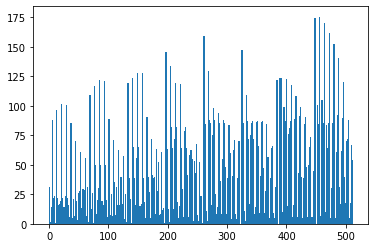

In [ ]:
def grad_hist(I):
  M, A = gradient_magnitude(I,o=5)

  v_unit = int(I.shape[0]//8)
  h_unit = int(I.shape[1]//8)

  H_ = []
  for v in range(8):
    for h in range(8):
      H = np.zeros(8)
      for y in range(v_unit):
        for x in range(h_unit):
          y_ = v*8+y
          x_ = h*8+x
          a_bin = int(np.floor(A[y_,x_]/(np.pi/4))) #(4),3 ... 1,0,-1 .. -4
          a_bin = 3 if a_bin == 4 else a_bin
          a_bin += 4 #0,...7
          H[a_bin] += M[y_,x_]
      #print(H)
      H_ = np.concatenate([H_,H])
  return(H_)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/museum.jpg')
plt.bar(np.arange(64*8),grad_hist(I),width=2)



In [ ]:
def compare_histograms(H1, H2, mode):
  if H1.shape != H2.shape:
    return None
  
  H1 = H1.reshape(-1)
  H2 = H2.reshape(-1)
  if mode == "L2":
    return np.sqrt(np.sum(np.square(H2 - H1)))
  elif mode == "X":
    e = 0.0000000001
    return (1/2) * np.sum(np.square(H2 - H1)/(H2 + H1 + e))
  elif mode == "intersection":
    return 1 - np.sum(np.minimum(H1,H2))
  elif mode == "hell":
    return np.sqrt(1/2 * np.sum(np.square(np.sqrt(H1)-np.sqrt(H2))))



n_bins = 3

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment1/images/bird.jpg')
H1 = grad_hist(I)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment1/images/coins.jpg')
H2 = grad_hist(I)

print(compare_histograms(H1,H2,"hell"))

86.03090774354185


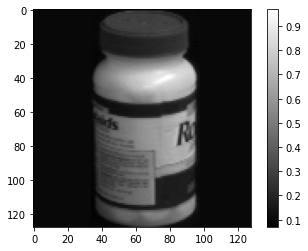

In [ ]:
I_ = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment2/dataset/object_05_4.png')
imshow(I_)
H_ = grad_hist(I).reshape(-1)



class Q:
  mode = None
  def __init__(self, name, image, n_bins):
      self.name = name
      self.image = image
      hist = grad_hist(image).reshape(-1)
      self.hist = hist
      self.dist = None
      if self.hist is None:
        print("HALLO")

  def __lt__(self, other):
    A = compare_histograms(self.hist, H_, Q.mode)
    B = compare_histograms(other.hist, H_, Q.mode)
    return A < B

def retrieve(folder, n_bins):
  qs = []
  for filename in os.listdir(folder):
      q = Q(name = filename,
            image = imread_gray(os.path.join(folder,filename)),
            n_bins = n_bins)
      if q.image is not None and q.hist is not None:
          qs.append(q)
      else:
        print("HERE")
  return qs


n_bins = 8
qss = {}
retrieved = retrieve("/content/drive/MyDrive/ColabNotebooks/assignment2/dataset/", n_bins)


for mode in ["L2", "X", "intersection", "hell"]:
  qss[mode] = list(retrieved)
  Q.mode = mode
  qss[mode].sort()

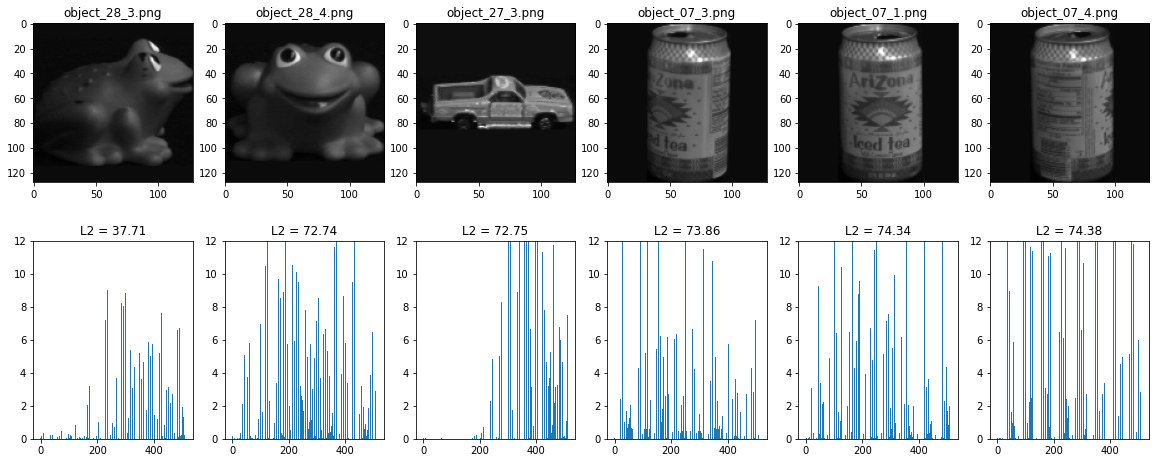

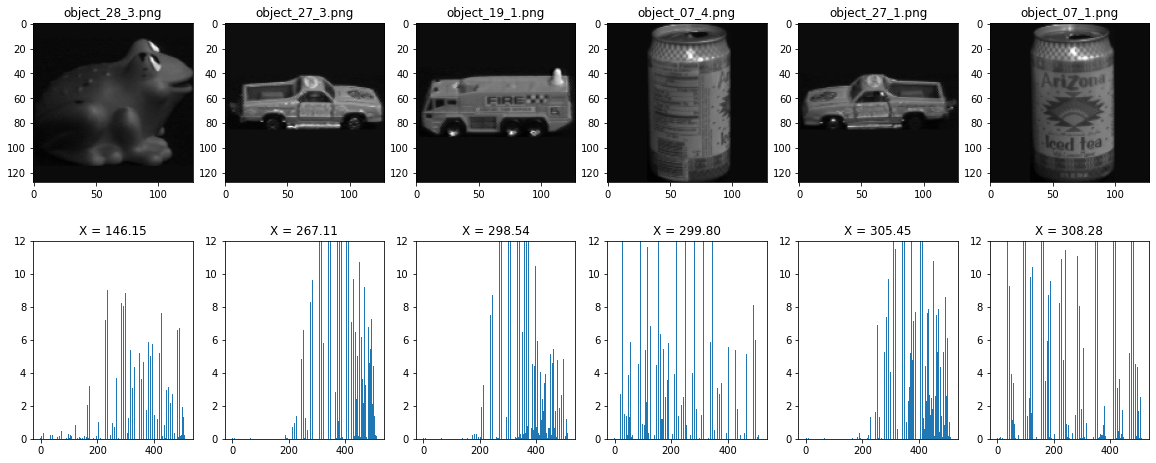

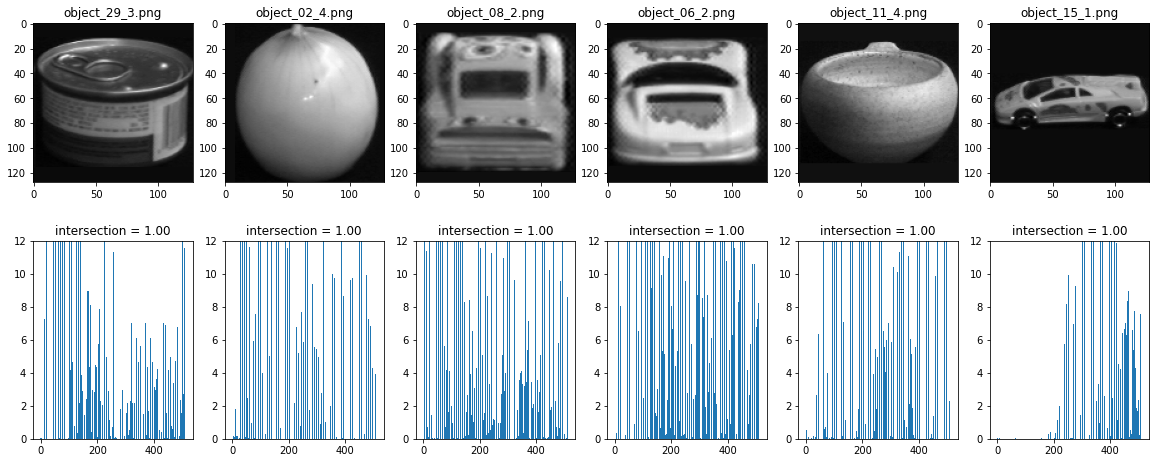

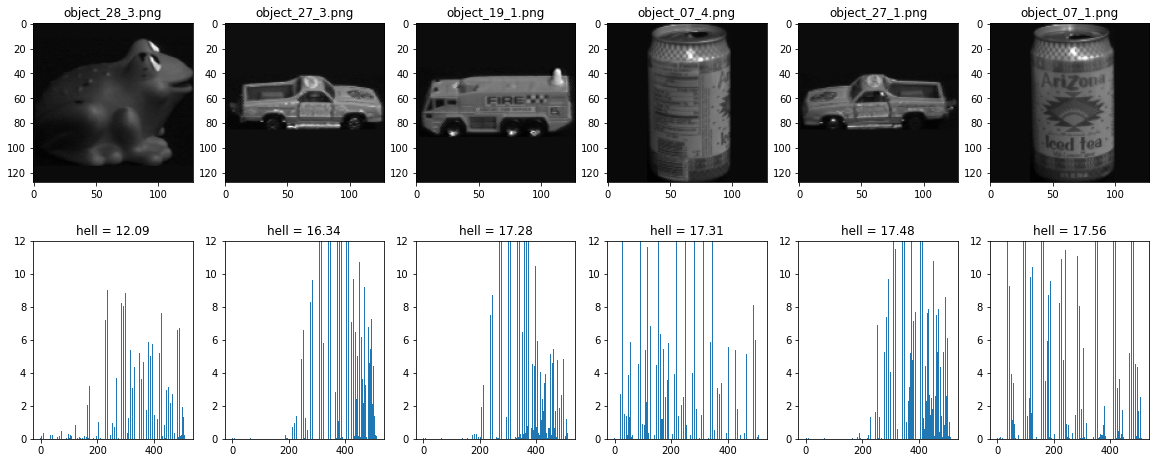

In [ ]:
for mode in ["L2", "X", "intersection", "hell"]:
  fig, axs = plt.subplots(2, 6, figsize=(20,8))

  for i, q in enumerate(qss[mode][:6]):
    axs[0, i].title.set_text(q.name)
    axs[0, i].imshow(q.image)
  
  y_max = 12
  for i, q in enumerate(qss[mode][:6]):
    axs[1, i].set_ylim(0,y_max)
    axs[1, i].title.set_text(f"{mode} = {compare_histograms(q.hist, H_, mode):.2f}")
    axs[1, i].bar(range(len(q.hist)), q.hist, width=2)

*EX* 2a OK

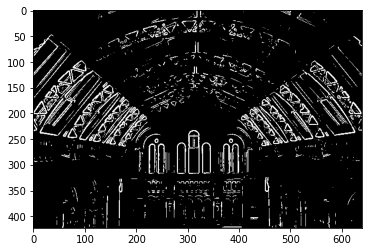

In [ ]:
def findedges(I,o=1,t=0.16): # I = gray
  M, A = gradient_magnitude(I,o)
  Ie = np.where(M>=t,1.,0.)
  return Ie

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/museum.jpg')
plt.imshow(findedges(I,o=1,t=0.16))
plt.imsave("/content/drive/MyDrive/ColabNotebooks/assignment3/images/edges.jpg",I);


EX 2b TODO kaj pomeni tresh = 0.16 ne dela, nisem zadovoljna



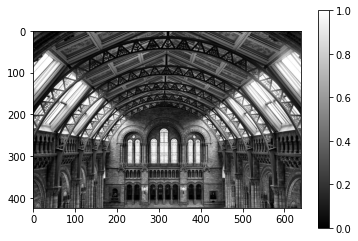

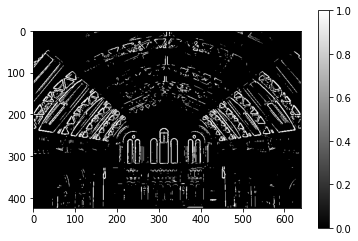

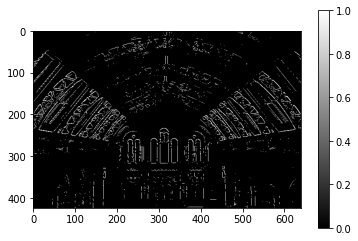

In [ ]:
def loc_max(A,M,x,y):
  a_bin = np.floor(A[y,x]/(np.pi/8)) #(8),7..1,0,-1..-8

  if a_bin in np.array([-1,0,7,-8,8]):
    max_neig_value = max(M[y,x-1],M[y,x+1])
  elif a_bin in np.array([1,2,-6,-7]):
    max_neig_value = max(M[y+1,x-1],M[y-1,x+1])
  elif a_bin in np.array([3,4,-4,-5]):
    max_neig_value = max(M[y-1,x],M[y+1,x])
  elif a_bin in np.array([5,6,-2,-3]):
    max_neig_value = max(M[y-1,x-1],M[y+1,x+1])
  else:
    print(f"neki: {a_bin}")

  return(A[y,x] >= max_neig_value)


def binarize(I,tresh=0.16):
  Ie = np.where(I>=tresh,1.,0.)
  return(Ie)


def non_maxima(I,o=0.5): # I = gray
  M,A = gradient_magnitude(I,o)
  I_ = np.copy(I)
  #print(I.shape)
  for x in range(1,len(I[0])-1):
    for y in range(1,len(I)-1):
      if not loc_max(A,M,x,y):
        I_[y,x] = 0
  return(I_)



I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/museum.jpg')
imshow(I)
I_tresholded = findedges(I)
imshow(I_tresholded)
I_non_maxima = non_maxima(I_tresholded)
I_non_maxima_binary = binarize(I_non_maxima)
imshow(I_non_maxima_binary)


EX 2c* TODO

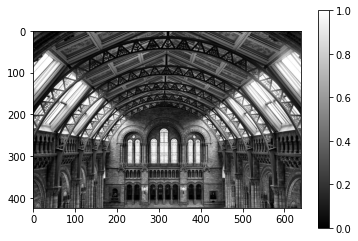

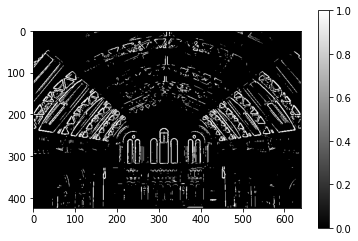

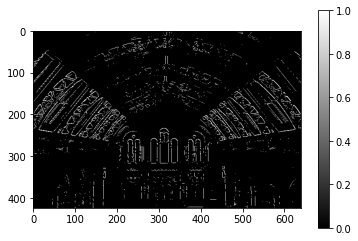

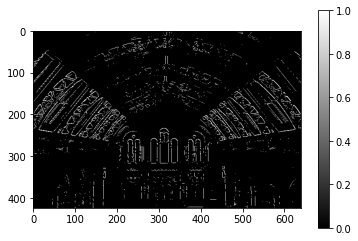

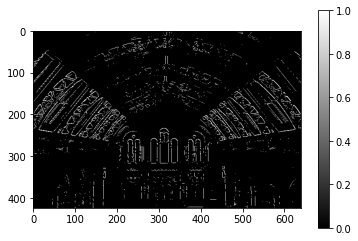

In [ ]:
def hysteresis(I,t_high,t_low):
  
  connectivity = 8

  I1 = np.where(I>t_low,I,0) # odpadejo sibki
  I1_binary = np.where(I>0,1,0).astype(np.uint8)

  _,I1_separated,stats1,_ = cv2.connectedComponentsWithStats(I1_binary, connectivity, cv2.CV_32S)


  IR = np.copy(I1)
  sizes = stats1[:, -1][1:]
  for niso_sibki in range(len(sizes)):
    if len([(I1_separated == niso_sibki) & (I1 > t_high)]) == 0: # nima niti enega mocnega piksla
      IR[I1_separated == niso_sibki+1] = 0
  
  return(IR)


I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/museum.jpg')
imshow(I)
I = findedges(I)
imshow(I)
I = non_maxima(I)
imshow(I)

I = hysteresis(I,t_high = 0.16, t_low = 0.04)
imshow(I)
imshow(binarize(I))


EX 3 question:



Analytically solve the problem by using Hough transform: In 2D space
you are given four points (0, 0), (1, 1), (1, 0), (2, 2). Define the equations of the lines that run through at least two of these points.

a (0,0): 0=m*0+c
b (1,1): 1=m*1+c
c (1,0): 0=m*1+c
d (2,2): 2=m*2+c

ab: c=0 => m=1
ac: c=0 => m=0
ad: c=0 => m=1
bc: c+m=0 , c+m=1 -><-
bd: c+m=1 => 2=2*m+(1-m) => 1=m => c=0
cd: c=-m => m=2 => c=-2

y=x, y=0, y=2*x-2

0,2 1,2 2,2

0,1 1,1 2,1

0,0 1,0 2,0


EX 3a OK

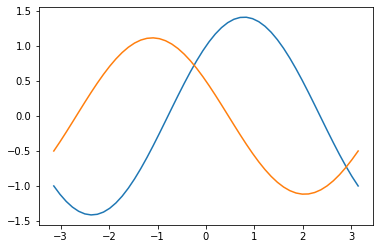

In [ ]:
def sinusoid(x,y):
  the = np.linspace(-np.pi, np.pi)
  ro = x*np.cos(the) + y*np.sin(the)
  plt.plot(the, ro)

sinusoid(1,1) # blue
sinusoid(1/2,-1) # orange


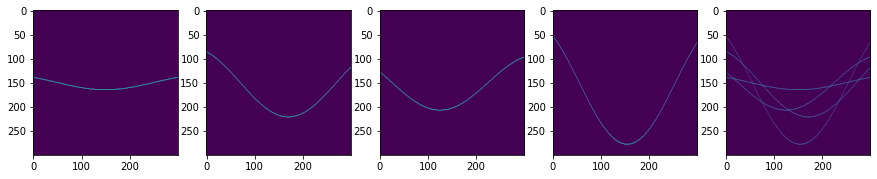

In [ ]:
def acc_mat(x_, y_, ro_nbins = 300, the_nbins = 300, D=np.sqrt(2*(300**2))/3, the0=-np.pi/2, the1=np.pi):
  A = np.zeros((ro_nbins, the_nbins))
  the = np.linspace(the0,the1,the_nbins) # -pi/2, pi
  ro = x_*np.cos(the) + y_*np.sin(the)
  ro_bin = np.floor((ro + D)/(2*D) * ro_nbins).astype('int')  
  
  A[ro_bin,np.arange(the_nbins)] += 1
  return(A)

_, ax = plt.subplots(1,5,figsize=(15, 15))
ax[0].imshow(acc_mat(10,10),cmap="viridis")
ax[1].imshow(acc_mat(30,60),cmap="viridis")
ax[2].imshow(acc_mat(50,20),cmap="viridis")
ax[3].imshow(acc_mat(80,90),cmap="viridis")

A = acc_mat(10,10)
A += acc_mat(30,60)
A += acc_mat(50,20)
A += acc_mat(80,90)


ax[4].imshow(A,cmap="viridis")




EX 3b DELA

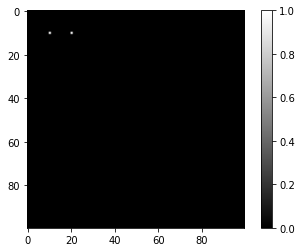

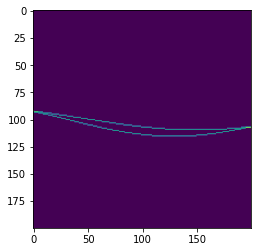

(288, 460)


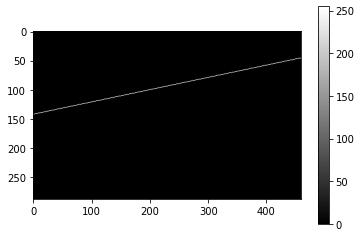

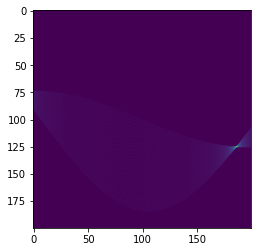

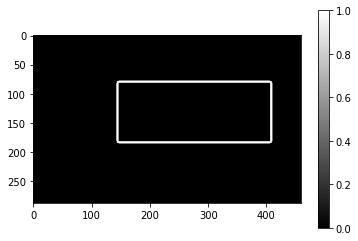

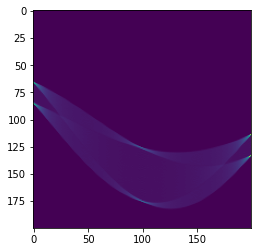

In [ ]:
def hough_find_lines(I, ro_nbins=200, the_nbins=200): #I = binary
  A = np.zeros((ro_nbins, the_nbins))

  for x in range(len(I[0])):
    for y in range(len(I)):
      if I[y,x] == 0: continue
      D = np.sqrt(I.shape[0]**2+I.shape[1]**2)
      the0 = -np.pi/2
      the1 = np.pi/2
      A += acc_mat(x,y,ro_nbins,the_nbins,D,the0,the1)

  return(A)


I = np.zeros((100,100))
I[10,10] = 1
I[10,20] = 1 # y,x
imshow(I)

A = hough_find_lines(I)
plt.imshow(A,cmap="viridis")

plt.show()

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/oneline.png')
I = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/ColabNotebooks/assignment3/images/oneline.png'),cv2.COLOR_BGR2GRAY)
print(I.shape)
I_edge = cv2.Canny(image=I, threshold1= 100, threshold2= 200)#findedges(I)
imshow(I_edge)
A = hough_find_lines(I_edge)
plt.imshow(A,cmap="viridis")

plt.show()

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/rectangle.png')
I_edge = findedges(I)
imshow(I_edge)
#nm = non_maxima(I_edge)

A = hough_find_lines(I_edge)
plt.imshow(A,cmap="viridis")







EX 3c DELA?

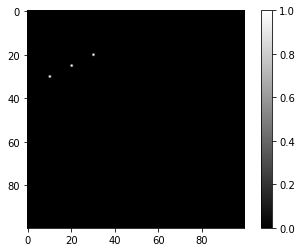

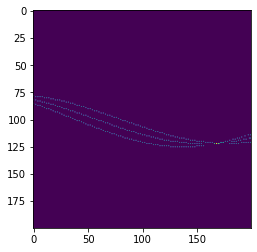

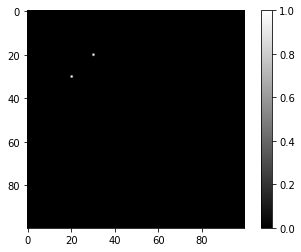

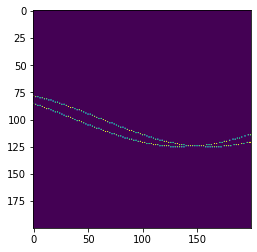

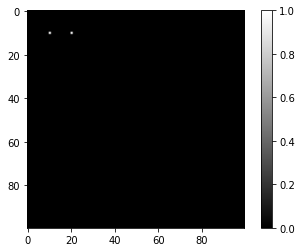

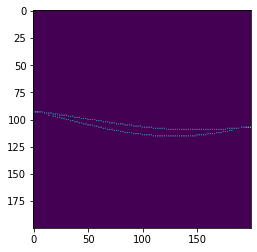

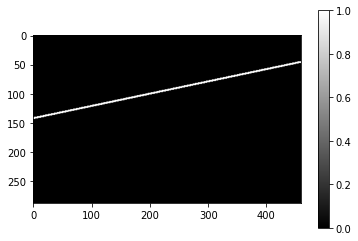

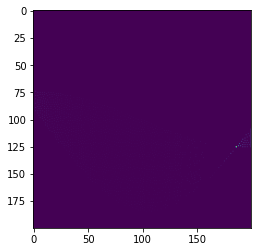

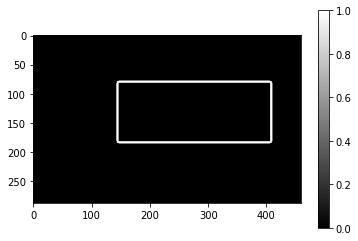

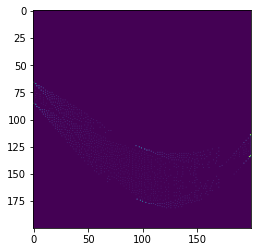

In [ ]:
def loc_max_box(A,y,x):
  #return (A[y,x] > max(A[y+1,x-1],A[y+1,x+1],A[y+1,x],A[y,x+1],A[y,x-1],A[y-1,x-1],A[y-1,x],A[y-1,x+1]))
  return (A[y,x] >= max(A[y+1,x-1],A[y+1,x+1],A[y+1,x],A[y,x+1]) and A[y,x] > max(A[y,x-1],A[y-1,x-1],A[y-1,x],A[y-1,x+1]))


def nonmaxima_suppression_box(A):
  A_ = np.copy(A)
  for x in range(1,len(A[0])-1):
    for y in range(1,len(A)-1):
      if not loc_max_box(A_,y,x):
        A_[y,x] = 0
  return(A_)

I = np.zeros((100,100))
I[30,10] = 1
I[25,20] = 1 # y,x
I[20,30] = 1 # y,x
imshow(I)

A = hough_find_lines(I)
A_supp = nonmaxima_suppression_box(A)
plt.imshow(A_supp,cmap="viridis")

plt.show()


I = np.zeros((100,100))
I[20,30] = 1
I[30,20] = 1
imshow(I)

A = hough_find_lines(I)
A_supp = nonmaxima_suppression_box(A)
plt.imshow(A_supp,cmap="viridis")

plt.show()



#################33

I = np.zeros((100,100))
I[10,10] = 1
I[10,20] = 1 # y,x
imshow(I)

A = hough_find_lines(I)
A_supp = nonmaxima_suppression_box(A)
plt.imshow(A_supp,cmap="viridis")

plt.show()

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/oneline.png')
I_edge = findedges(I)
imshow(I_edge)
A = hough_find_lines(I_edge)
A_supp = nonmaxima_suppression_box(A)
plt.imshow(A_supp,cmap="viridis")

plt.show()

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/rectangle.png')
I_edge = findedges(I)
imshow(I_edge)
A = hough_find_lines(I_edge)
A_supp = nonmaxima_suppression_box(A)
plt.imshow(A_supp,cmap="viridis")

EX 3d DELA

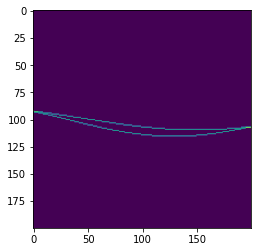

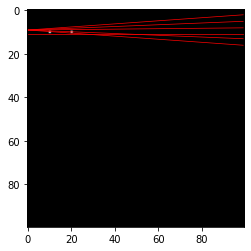

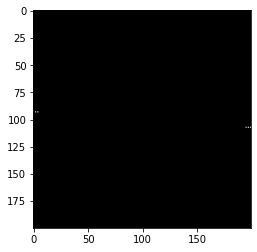

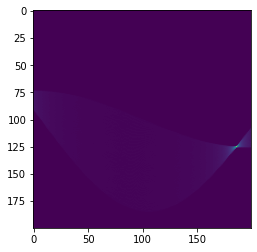

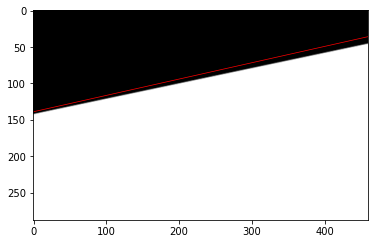

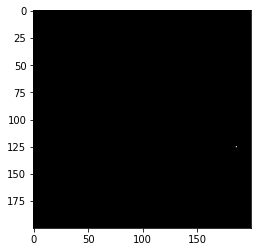

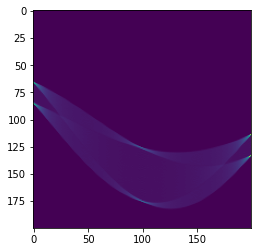

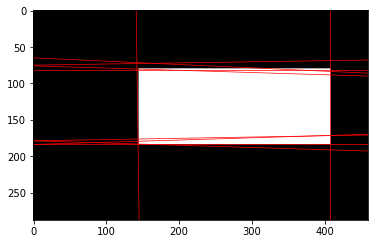

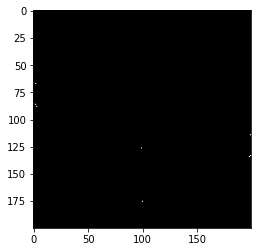

In [ ]:
def draw_lines(I_org,I, draw_tresh = 1, ro_n_bins = 200, the_n_bins = 200):
  A = hough_find_lines(I, ro_n_bins, the_n_bins)
  plt.imshow(A,cmap="viridis")
  plt.show()
  A = nonmaxima_suppression_box(A)
  B = np.zeros(A.shape)
  for the in range(len(A[0])):
    for ro in range(len(A)):
      if A[ro,the] >= draw_tresh:
        B[ro,the] = 1
        D = np.sqrt(I.shape[0]**2+I.shape[1]**2)
        ro_ = (ro / ro_n_bins) * (2*D) - D
        the_ = (the/the_n_bins * np.pi) - np.pi/2
        draw_line(ro_,the_,I.shape[0],I.shape[1])

  plt.imshow(I_org)
  plt.show()
  plt.imshow(B)
  plt.show()


I = np.zeros((100,100))
I[10,10] = 1
I[10,20] = 1 # y,x
draw_lines(I,I,2)


I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/oneline.png')
I_edge = findedges(I)
draw_lines(I,I_edge,1000)


I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/rectangle.png')
I_edge = findedges(I)
draw_lines(I,I_edge,400)

EX 3e DELA

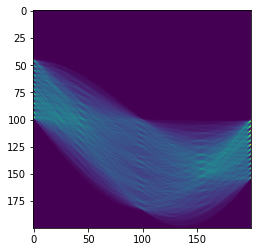

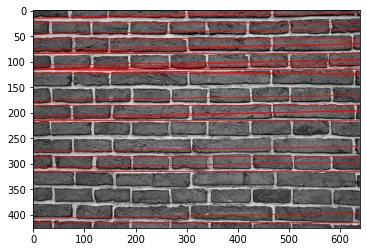

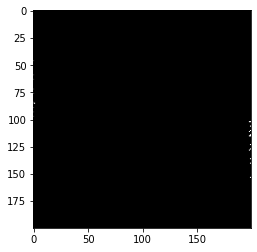

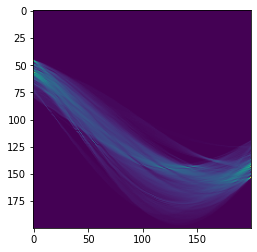

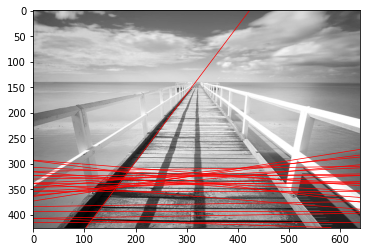

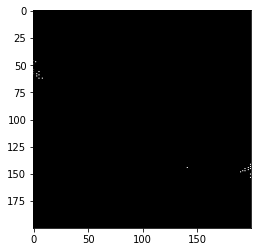

In [ ]:
I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/bricks.jpg')
I_edge = findedges(I)
draw_lines(I,I_edge,1400)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/pier.jpg')
I_edge = findedges(I)
draw_lines(I,I_edge,600)

EX 3f*

Results are more clean, the steepness is more correct. On brick wall we also get vertical lines.

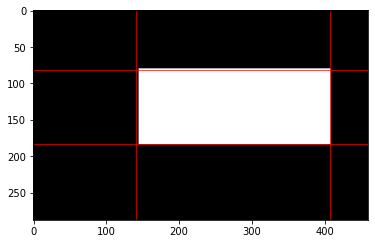

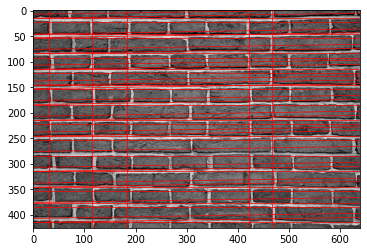

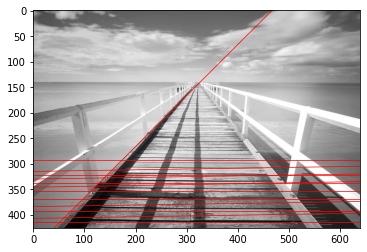

In [ ]:
def acc_mat_spec(x_, y_, ro_nbins, the_nbins, D, Angle):
  A = np.zeros((ro_nbins, the_nbins))
  #the = np.linspace(the0,the1,the_nbins) # -pi/2, pi
  the = ((Angle[y_,x_] +np.pi/2) % np.pi) - np.pi/2
  the_bin = int(np.floor((the + np.pi/2)/np.pi * the_nbins))
  the_bin = the_nbins-1 if the_bin == the_nbins else the_bin
  ro = x_*np.cos(the) + y_*np.sin(the)
  ro_bin = np.floor((ro + D)/(2*D) * ro_nbins).astype('int')  
  #print(the_bin)
  A[ro_bin,the_bin] += 1
  return(A)

def hough_find_lines_spec(I, ro_nbins=200, the_nbins=200): #I = binary
  A = np.zeros((ro_nbins, the_nbins))
  M,Angle = gradient_magnitude(I,o=1)

  for x in range(len(I[0])):
    for y in range(len(I)):
      if I[y,x] == 0: continue
      D = np.sqrt(I.shape[0]**2+I.shape[1]**2)
      the0 = -np.pi/2
      the1 = np.pi/2
      A += acc_mat_spec(x,y,ro_nbins,the_nbins,D,Angle)

  return(A)

def draw_lines_spec(I_org,I, draw_tresh = 1, ro_n_bins = 200, the_n_bins = 200):
  A = hough_find_lines_spec(I, ro_n_bins, the_n_bins)
  #plt.imshow(A,cmap="viridis")
  #plt.show()
  A = nonmaxima_suppression_box(A)
  B = np.zeros(A.shape)
  for the in range(len(A[0])):
    for ro in range(len(A)):
      if A[ro,the] >= draw_tresh:
        B[ro,the] = 1
        D = np.sqrt(I.shape[0]**2+I.shape[1]**2)
        ro_ = (ro / ro_n_bins) * (2*D) - D
        the_ = (the/the_n_bins * np.pi) - np.pi/2
        draw_line(ro_,the_,I.shape[0],I.shape[1])

  plt.imshow(I_org)
  plt.show()
  #plt.imshow(B)
  #plt.show()

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/rectangle.png')
I_edge = findedges(I)
draw_lines_spec(I,I_edge,270)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/bricks.jpg')
I_edge = findedges(I)
draw_lines_spec(I,I_edge,80)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/pier.jpg')
I_edge = findedges(I)
draw_lines_spec(I,I_edge,80)

EX 3g*

EX 3h*

How many pixels does a line (lin function) cross? the and ro fixed => num of pixels in I

mat: zeros, draw_line = > len(mat == "r")

In [ ]:
import scipy.misc
import numpy as np
from skimage.draw import line_aa

def get_y2(x,ro,the):
  if np.sin(the) == 0:
    return int(np.floor((ro - x*np.cos(the))/(np.sin(the)-0.00000001)))
  return int(np.floor((ro - x*np.cos(the))/np.sin(the)))

def num_pixels2(I_shape, ro, the):
  mat = np.zeros((I_shape[0],I_shape[1],3), dtype=np.uint8)
  y1 = get_y(0,ro,the)
  y2 = get_y(I_shape[0],ro,the)
  #print(y1,y2)
  mat = cv2.line(mat, (0,y1), (I_shape[1],y2), color = (0, 255, 0),thickness = 9)
  #imshow(mat[:,:,1])
  mat1 = mat[:,:,1]
  return(len(mat1[mat1>0]))

#I = np.zeros((20,21,3), dtype=np.uint8)
I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/rectangle.png')
print(num_pixels(I.shape,5,3))
print(num_pixels(I.shape,5,2))
print(num_pixels(I.shape,10,3))
print(num_pixels(I.shape,10,2))

NameError: ignored

In [ ]:
def get_y(x,ro,the):
  if np.sin(the) == 0:
    return int(np.floor((ro - x*np.cos(the))/(np.sin(the)-0.00000001)))
  return int(np.floor((ro - x*np.cos(the))/np.sin(the)))

def get_x(y,ro,the):
  x = (ro - y*np.sin(the)) / np.cos(the)
  if np.cos(the) == 0:
    return int(np.floor((ro - y*np.sin(the)) / np.cos(the)-0.00000001))
  return int(np.floor((ro - y*np.sin(the)) / np.cos(the)))

def v(v,n1,n2):
  return (n1 < v) & (v < n2)

def num_pixels(I_shape, ro, the):
  # L R U D => 0,1,2,3

  xs = np.array((0,I.shape[1], get_x(0,ro,the), get_x(I.shape[0],ro,the)))
  ys = np.array((get_y(0,ro,the), get_y(I.shape[1],ro,the), 0, I.shape[0]))
  #print(xs)
  #print(ys)

  if len(v(xs,0,I.shape[1])) == 2: #navpicno
    dx = xs[ys == 0] - xs[ys == I.shape[0]]
    dy = I.shape[0]
  elif len(v(ys,0,I.shape[0])) == 2: #vodoravno
    dx = I.shape[1]
    dy = ys[xs == 0] - ys[xs == I.shape[1]]
  elif len((0 == xs) & (v(ys,0,I.shape[0]))) == 1: #seka na levi
    dy = ys[xs==0]
    if len((0 == ys) & (v(xs,0,I.shape[1]))) == 1:
      dx = xs[ys==0]
    else:
      dx = xs[ys==I.shape[0]]
  else:
    dy = ys[xs==I.shape[1]]
    if len((0 == ys) & (v(xs,0,I.shape[1]))) == 1:
      dx = xs[ys==0]
    else:
      dx = xs[ys==I.shape[0]]
  
  l = np.sqrt(dx**2 + dy**2)[0]
  return(l)

num_pixels2((20,30),5,2)



In [ ]:
def acc_mat_norm(x_, y_, I_shape=(20,30,3), ro_nbins = 300, the_nbins = 300, D=np.sqrt(2*(300**2))/3, the0=-np.pi/2, the1=np.pi):
  A = np.zeros((ro_nbins, the_nbins))
  the = np.linspace(the0,the1,the_nbins) # -pi/2, pi
  ro = x_*np.cos(the) + y_*np.sin(the)
  ro_bin = np.floor((ro + D)/(2*D) * ro_nbins).astype('int')  
  the_bin = np.arange(the_nbins)
  
  for i in range(len(ro_bin)):
    numP = num_pixels(I_shape,ro[i],the[i])
    if numP != 0:
      A[ro_bin[i],the_bin[i]] += 1/numP
  return(A)

def hough_find_lines_norm(I, ro_nbins=200, the_nbins=200): #I = binary
  A = np.zeros((ro_nbins, the_nbins))

  for x in range(len(I[0])):
    for y in range(len(I)):
      if I[y,x] == 0: continue
      D = np.sqrt(I.shape[0]**2+I.shape[1]**2)
      the0 = -np.pi/2
      the1 = np.pi/2
      A += acc_mat_norm(x,y,I.shape,ro_nbins,the_nbins,D,the0,the1)

  return(A)

def draw_lines_norm(I_org,I, draw_tresh = 1, ro_n_bins = 200, the_n_bins = 200):
  A = hough_find_lines_norm(I, ro_n_bins, the_n_bins)
  plt.imshow(A,cmap="viridis")
  plt.show()
  A = nonmaxima_suppression_box(A)
  B = np.zeros(A.shape)
  for the in range(len(A[0])):
    for ro in range(len(A)):
      if A[ro,the] >= draw_tresh:
        B[ro,the] = 1
        D = np.sqrt(I.shape[0]**2+I.shape[1]**2)
        ro_ = (ro / ro_n_bins) * (2*D) - D
        the_ = (the/the_n_bins * np.pi) - np.pi/2
        draw_line(ro_,the_,I.shape[0],I.shape[1])

  plt.imshow(I_org)
  plt.show()
  plt.imshow(B)
  plt.show()


I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/rectangle.png')
I_edge = findedges(I)
draw_lines_norm(I,I_edge,10)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/bricks.jpg')
I_edge = findedges(I)
draw_lines_norm(I,I_edge,80)

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment3/images/pier.jpg')
I_edge = findedges(I)
draw_lines_norm(I,I_edge,80)